In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math
from tensorflow.keras.layers import LSTM, RNN, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import os

In [2]:
data_balance = pd.read_csv('data/user_balance_table.csv')

In [3]:
data_balance['date'] = pd.to_datetime(data_balance['report_date'],format="%Y%m%d")
data_balance['day'] = data_balance['date'].dt.day
data_balance['month'] = data_balance['date'].dt.month
data_balance['year'] = data_balance['date'].dt.year
data_balance['week'] = data_balance['date'].dt.week
data_balance['weekday'] = data_balance['date'].dt.weekday

<ipython-input-3-f87924ee274e>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_balance['week'] = data_balance['date'].dt.week


In [4]:
total_balance = data_balance.groupby(['date'])['total_purchase_amt','total_redeem_amt'].sum()
total_balance.reset_index(inplace=True)

<ipython-input-4-de8c29956373>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_balance = data_balance.groupby(['date'])['total_purchase_amt','total_redeem_amt'].sum()


In [5]:
total_balance.to_csv('data/simple_lstm_data.csv')

In [15]:
class LSTMModel(object):
    def __init__(self, look_back=1, epochs_purchase=20, epochs_redeem=40, batch_size=1, verbose=2, patience=10, store_result=False):
        self.look_back = look_back
        self.epochs_purchase = epochs_purchase
        self.epochs_redeem = epochs_redeem
        self.batch_size = batch_size
        self.verbose = verbose
        self.store_result = store_result
        self.patience = patience
        self.purchase = pd.read_csv("data/simple_lstm_data.csv", usecols=[2], engine='python') 
        self.redeem = pd.read_csv("data/simple_lstm_data.csv",usecols=[3], engine='python')
        
    def access_data(self, data_frame):
        data_set = data_frame.values
        data_set = data_set.astype('float32')

        scaler = MinMaxScaler(feature_range=(0, 1))
        data_set = scaler.fit_transform(data_set)

        train_x, train_y, test = self.create_data_set(data_set)

        train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
        return train_x, train_y, test, scaler

    def create_data_set(self, data_set):
        data_x, data_y = [], []
        for i in range(len(data_set)-self.look_back - 30):
            a = data_set[i:(i + self.look_back), 0]
            data_x.append(a)
            data_y.append(list(data_set[i + self.look_back: i + self.look_back + 30, 0]))
        return np.array(data_x), np.array(data_y), data_set[-self.look_back:, 0].reshape(1, 1, self.look_back)
    
    def rnn_model(self, train_x, train_y, epochs):
        model = Sequential()
        model.add(LSTM(64, input_shape=(1, self.look_back), return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(32))
        model.add(Dense(30))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.summary()
        early_stopping = EarlyStopping('loss', patience=self.patience)
        history = model.fit(train_x, train_y, epochs=epochs, batch_size=self.batch_size, verbose=self.verbose, callbacks=[early_stopping])
        return model

    def predict(self, model, data):
        prediction = model.predict(data)
        return prediction

    def plot_show(self, predict):
        predict = predict[['purchase', 'redeem']]
        predict.plot()
        plt.show()

    def run(self):
        purchase_train_x, purchase_train_y, purchase_test, purchase_scaler = self.access_data(self.purchase)
        redeem_train_x, redeem_train_y, redeem_test, redeem_scaler = self.access_data(self.redeem)

        purchase_model = self.rnn_model(purchase_train_x, purchase_train_y, self.epochs_purchase)
        redeem_model = self.rnn_model(redeem_train_x, redeem_train_y, self.epochs_redeem)

        purchase_predict = self.predict(purchase_model, purchase_test)
        redeem_predict = self.predict(redeem_model, redeem_test)

        test_res = pd.DataFrame({'report_date': [20140900 + i for i in range(1, 31)]})

        purchase = purchase_scaler.inverse_transform(purchase_predict).reshape(30, 1)
        redeem = redeem_scaler.inverse_transform(redeem_predict).reshape(30, 1)

        test_res['purchase'] = purchase
        test_res['redeem'] = redeem
        print(test_res)

        if self.store_result is True:
            test_res.to_csv('result/submit_simple_lstm.csv', encoding='utf-8', index=None, header=None)
            
        self.plot_show(test_res)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 64)             26880     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 30)                990       
Total params: 41,342
Trainable params: 41,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
23/23 - 4s - loss: 0.0671
Epoch 2/150
23/23 - 0s - loss: 0.0267
Epoch 3/150
23/23 - 0s - loss: 0.0176
Epoch 4/150
23/23 - 0s - loss: 0.0168
Epoch 5/150
23/23 - 0s - loss: 0.0164
Epoch 6/150
23/23 - 0s - loss: 0.0160
Epoch 7/150
23/23 - 

Epoch 15/250
23/23 - 0s - loss: 0.0202
Epoch 16/250
23/23 - 0s - loss: 0.0199
Epoch 17/250
23/23 - 0s - loss: 0.0197
Epoch 18/250
23/23 - 0s - loss: 0.0194
Epoch 19/250
23/23 - 0s - loss: 0.0192
Epoch 20/250
23/23 - 0s - loss: 0.0190
Epoch 21/250
23/23 - 0s - loss: 0.0191
Epoch 22/250
23/23 - 0s - loss: 0.0185
Epoch 23/250
23/23 - 0s - loss: 0.0182
Epoch 24/250
23/23 - 0s - loss: 0.0180
Epoch 25/250
23/23 - 0s - loss: 0.0177
Epoch 26/250
23/23 - 0s - loss: 0.0174
Epoch 27/250
23/23 - 0s - loss: 0.0172
Epoch 28/250
23/23 - 0s - loss: 0.0172
Epoch 29/250
23/23 - 0s - loss: 0.0173
Epoch 30/250
23/23 - 0s - loss: 0.0168
Epoch 31/250
23/23 - 0s - loss: 0.0167
Epoch 32/250
23/23 - 0s - loss: 0.0165
Epoch 33/250
23/23 - 0s - loss: 0.0165
Epoch 34/250
23/23 - 0s - loss: 0.0162
Epoch 35/250
23/23 - 0s - loss: 0.0162
Epoch 36/250
23/23 - 0s - loss: 0.0160
Epoch 37/250
23/23 - 0s - loss: 0.0160
Epoch 38/250
23/23 - 0s - loss: 0.0160
Epoch 39/250
23/23 - 0s - loss: 0.0158
Epoch 40/250
23/23 - 0s -

Epoch 222/250
23/23 - 0s - loss: 0.0112
Epoch 223/250
23/23 - 0s - loss: 0.0111
Epoch 224/250
23/23 - 0s - loss: 0.0113
Epoch 225/250
23/23 - 0s - loss: 0.0114
Epoch 226/250
23/23 - 0s - loss: 0.0112
Epoch 227/250
23/23 - 0s - loss: 0.0110
Epoch 228/250
23/23 - 0s - loss: 0.0111
Epoch 229/250
23/23 - 0s - loss: 0.0110
Epoch 230/250
23/23 - 0s - loss: 0.0112
Epoch 231/250
23/23 - 0s - loss: 0.0112
Epoch 232/250
23/23 - 0s - loss: 0.0111
Epoch 233/250
23/23 - 0s - loss: 0.0111
Epoch 234/250
23/23 - 0s - loss: 0.0110
Epoch 235/250
23/23 - 0s - loss: 0.0110
Epoch 236/250
23/23 - 0s - loss: 0.0109
Epoch 237/250
23/23 - 0s - loss: 0.0109
Epoch 238/250
23/23 - 0s - loss: 0.0110
Epoch 239/250
23/23 - 0s - loss: 0.0109
Epoch 240/250
23/23 - 0s - loss: 0.0110
Epoch 241/250
23/23 - 0s - loss: 0.0109
Epoch 242/250
23/23 - 0s - loss: 0.0108
Epoch 243/250
23/23 - 0s - loss: 0.0109
Epoch 244/250
23/23 - 0s - loss: 0.0108
Epoch 245/250
23/23 - 0s - loss: 0.0108
Epoch 246/250
23/23 - 0s - loss: 0.0108


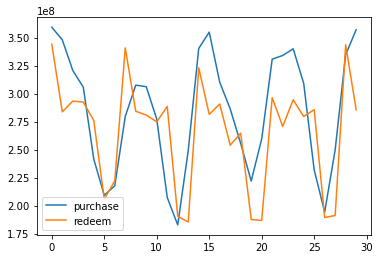

In [16]:
experiment1 = LSTMModel(look_back=40, epochs_purchase=150, epochs_redeem=250, batch_size=16, verbose=2, patience=50, store_result=True)
experiment1.run()